### Initialization

In [ ]:
!git clone https://github.com/InterDigitalInc/FeatureStyleEncoder.git
%cd FeatureStyleEncoder

In [ ]:
!./download_models.sh

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

import argparse
import glob
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import yaml

from PIL import Image
from tqdm import tqdm
from torchvision import transforms, utils
from utils.functions import *

from trainer import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True
torch.autograd.set_detect_anomaly(True)
Image.MAX_IMAGE_PIXELS = None

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu') 

parser = argparse.ArgumentParser()
parser.add_argument('--config', type=str, default='001', help='Path to the config file.')
parser.add_argument('--pretrained_model_path', type=str, default='./pretrained_models/143_enc.pth', help='pretrained stylegan2 model')
parser.add_argument('--stylegan_model_path', type=str, default='./pixel2style2pixel/pretrained_models/psp_ffhq_encode.pt', help='pretrained stylegan2 model')
parser.add_argument('--arcface_model_path', type=str, default='./pretrained_models/backbone.pth', help='pretrained arcface model')
parser.add_argument('--parsing_model_path', type=str, default='./pretrained_models/79999_iter.pth', help='pretrained parsing model')
parser.add_argument('--log_path', type=str, default='./logs/', help='log file path')
parser.add_argument('--resume', action='store_true', help='resume from checkpoint')
parser.add_argument('--checkpoint', type=str, default='', help='checkpoint file path')
parser.add_argument('--checkpoint_noiser', type=str, default='', help='checkpoint file path')
parser.add_argument('--multigpu', type=bool, default=False, help='use multiple gpus')
parser.add_argument('--input_path', type=str, default='./test/', help='evaluation data file path')
parser.add_argument('--save_path', type=str, default='./', help='output data save path')
opts = parser.parse_args([])

In [16]:
img_to_tensor = transforms.Compose([
    transforms.Resize((1024, 1024)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

config = yaml.load(open('./configs/' + opts.config + '.yaml', 'r'), Loader=yaml.FullLoader)

# Initialize trainer
trainer = Trainer(config, opts)
trainer.initialize(opts.stylegan_model_path, opts.arcface_model_path, opts.parsing_model_path)  
trainer.to(device)

state_dict = torch.load(opts.pretrained_model_path)#os.path.join(opts.log_path, opts.config + '/checkpoint.pth'))
trainer.enc.load_state_dict(torch.load(opts.pretrained_model_path))
trainer.enc.eval()

print('Load pretrained model')

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/ubuntu/yaox/code/eccv_code/lpips/weights/v0.1/alex.pth
Load pretrained model


### Inversion

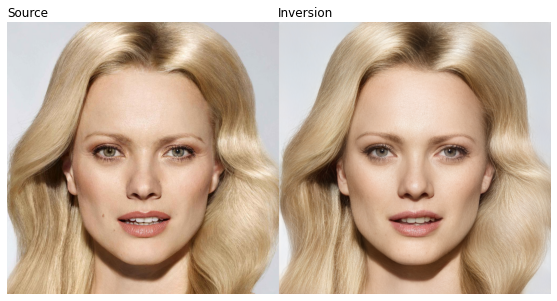

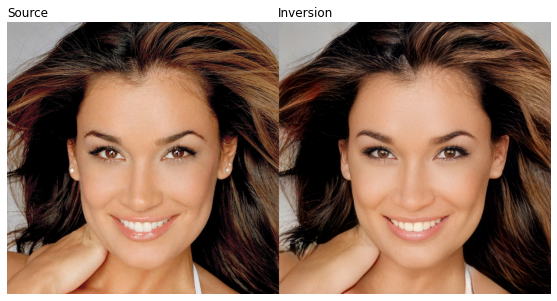

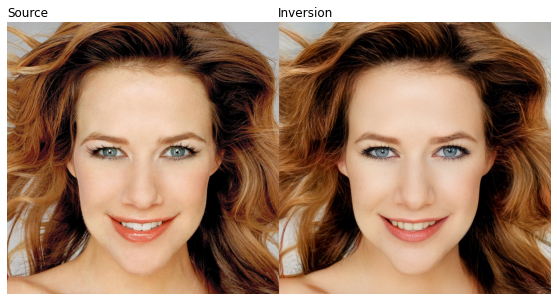

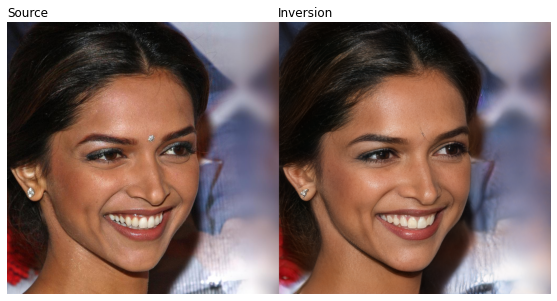

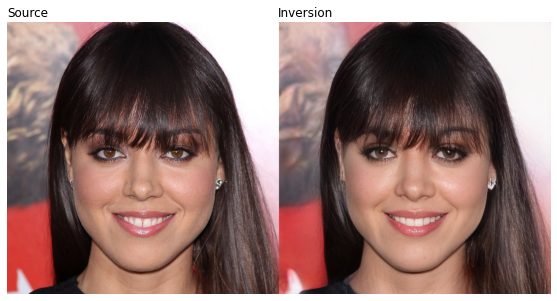

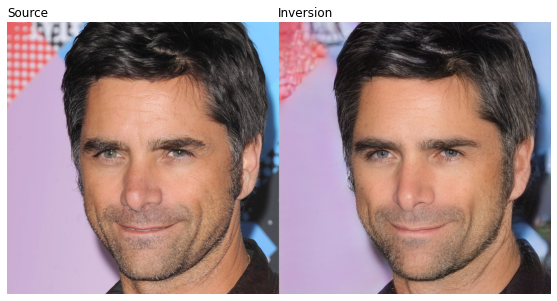

In [17]:
with torch.no_grad():
    
    img_list = [glob.glob1(opts.input_path, ext) for ext in ['*jpg','*png']]
    img_list = [item for sublist in img_list for item in sublist]
    img_list.sort()
    
    for i, img_name in enumerate(img_list):
        
        image_A = img_to_tensor(Image.open(opts.input_path + img_name)).unsqueeze(0).to(device)
        output = trainer.test(img=image_A, return_latent=True)
        feature = output.pop()
        latent = output.pop()
        
        img = torch.cat(output, dim=3)
        img = np.clip(clip_img(img)[0].cpu().numpy()*255.,0,255).astype(np.uint8)
        img = Image.fromarray(img.transpose(1,2,0))
        
        plt.figure(figsize=(10,5))
        plt.text(0, -20, 'Source', size='large')
        plt.text(1020, -20, 'Inversion', size='large')
        plt.axis('off')
        plt.imshow(img)
        plt.show()
        
        

### Latent space editing

In [18]:
# linear interpolation
def linear_interpolate(latent_code,
                       boundary,
                       start_distance=-3.0,
                       end_distance=3.0,
                       steps=10):
    assert (latent_code.shape[0] == 1 and boundary.shape[0] == 1 and
                    len(boundary.shape) == 2 and
                    boundary.shape[1] == latent_code.shape[-1])

    linspace = np.linspace(start_distance, end_distance, steps)
    if len(latent_code.shape) == 2:
        linspace = linspace.reshape(-1, 1).astype(np.float32)
        return latent_code + linspace * boundary
    if len(latent_code.shape) == 3:
        linspace = linspace.reshape(-1, 1, 1).astype(np.float32)
        return latent_code + linspace * boundary.reshape(1, 1, -1)

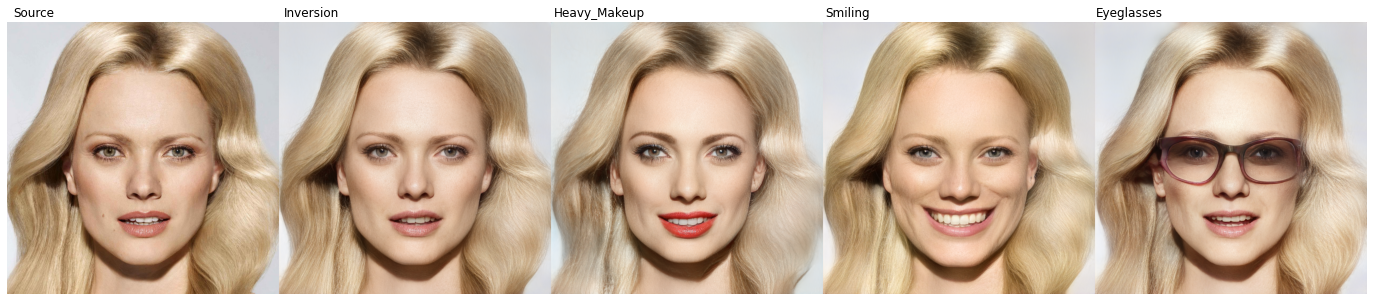

In [19]:
boundary_dir = './boundaries_ours/'
n_steps = 5
delta_on_feature = True
step_scale = 15

with torch.no_grad():
    
    img_A = img_to_tensor(Image.open(opts.input_path + '%05d.jpg' % 20)).unsqueeze(0).to(device)
    output = trainer.test(img=img_A, return_latent=True)
    feature = output.pop()
    latent = output.pop()
    
    for attr in ['Heavy_Makeup', 'Smiling', 'Eyeglasses']:

        boundary = np.load(boundary_dir +'%s_boundary.npy'%attr)
        w_0 = latent.cpu().numpy().reshape(1, -1)
        out = linear_interpolate(w_0, boundary, start_distance=-step_scale, end_distance=step_scale, steps=n_steps)
        w_0 = torch.tensor(w_0).view(1, -1, 512).to(device)
  
        for j in [4]:
            w_1 = torch.tensor(out[j]).view(1, -1, 512).to(device)
            
            # calculate delta feature
            _, fea_0 = trainer.StyleGAN([w_0], input_is_latent=True, return_features=True)
            _, fea_1 = trainer.StyleGAN([w_1], input_is_latent=True, return_features=True)
            
            features = [None]*5 + [feature + fea_1[5] - fea_0[5]] + [None]*(17-5)
            x_1, _ = trainer.StyleGAN([w_1], input_is_latent=True, features_in=features, feature_scale=1.0)
    
            output.append(x_1.data)

out = torch.cat(output, dim=3)
img = np.clip(clip_img(downscale(out))[0].cpu().numpy()*255.,0,255).astype(np.uint8)
img = Image.fromarray(img.transpose(1,2,0))
plt.figure(figsize=(25,5))
for i, ss in enumerate(['Source', 'Inversion', 'Heavy_Makeup', 'Smiling', 'Eyeglasses']):
    plt.text(10+i*510, -10, ss, size='large')
plt.axis('off')
plt.imshow(img)
plt.show()

### Style mixing

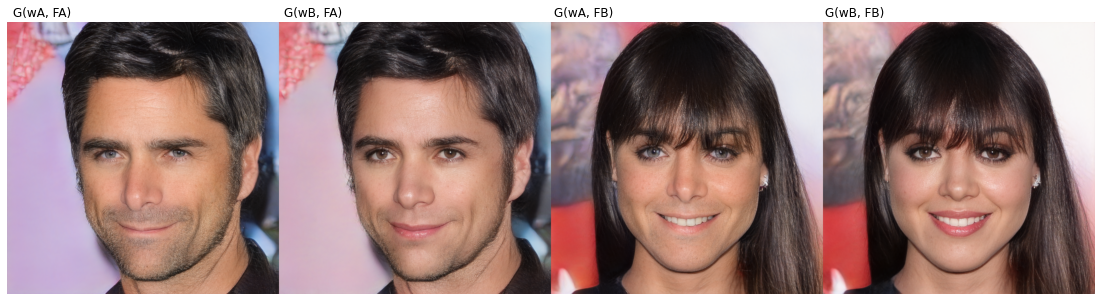

In [20]:
with torch.no_grad():
    
    image_A = img_to_tensor(Image.open(opts.input_path + '%05d.jpg' % 962)).unsqueeze(0).to(device)    
    w_0, fea_0 = trainer.encode(image_A)
    
    image_B = img_to_tensor(Image.open(opts.input_path + '%05d.jpg' % 610)).unsqueeze(0).to(device)    
    w_1, fea_1 = trainer.encode(image_B)
    
    idx_k = 5
    features = [None]*idx_k + [fea_0] + [None]*(17-idx_k)
    
    x_0, _ = trainer.StyleGAN([w_0], input_is_latent=True, features_in=features)
    x_1, _ = trainer.StyleGAN([w_1], input_is_latent=True, features_in=features)

    features = [None]*idx_k + [fea_1] + [None]*(17-idx_k)
    x_2, _ = trainer.StyleGAN([w_0], input_is_latent=True, features_in=features)
    x_3, _ = trainer.StyleGAN([w_1], input_is_latent=True, features_in=features)

    img_l = [x_0, x_1, x_2, x_3]
    out = torch.cat(img_l, dim=3)
    img = np.clip(clip_img(downscale(out))[0].cpu().numpy()*255.,0,255).astype(np.uint8)
    img = Image.fromarray(img.transpose(1,2,0))

plt.figure(figsize=(20,5))
for i, ss in enumerate(['G(wA, FA)', 'G(wB, FA)', 'G(wA, FB)', 'G(wB, FB)']):
    plt.text(10+i*510, -10, ss, size='large')
plt.axis('off')
plt.imshow(img)
plt.show()
